In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import yfinance as yf
from scipy.optimize import minimize


### Introduction: A simple Optimization problem using Scipy

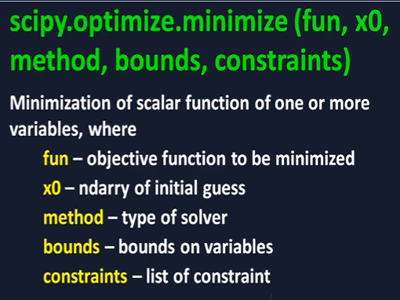

In [2]:
img1 = Image.open('optimization.png').resize((400,300))
display(img1)

### objective function: minimize  $f(x_1, x_2) = (x_1-1)^2 + (x_2-2/5)^2 - x_1x_2$
#### constrains st: 
$x_1-2x_2+2\ge2$ 

$-x_1-2x_2+6\ge4$
#### bounds on x1, x2:
$x_1\ge0$

$x_2\ge0$

In [3]:
def objective_f(x): # define objective function, note: x is a list. 
    x1= x[0]
    x2= x[1]
    return (x1-1)**2+(x2-2/5)**2-x1*x2

In [4]:
def constraint_f1(x): # define constraint function 1
    x1= x[0]
    x2= x[1]
    return x1-2*x2+2-2 # note: I moved '2' to the left of the inequation. 
                       # SciPy interprets 'expression (≥ 0)' as an inequality constraint, in this case, 𝑥1−2𝑥2+2-2 ≥ 0. 

In [5]:
def constraint_f2(x): # define constraint function 2
    x1= x[0]
    x2= x[1]
    return -x1-2*x2+6-4 # note: I moved '4' to the left of the inequation. −𝑥1−2𝑥2+6-4 ≥ 0

In [6]:
constraint1 = {'type': 'ineq', 'fun':constraint_f1} # assign constraint1, it is a dictionary 
constraint2 = {'type': 'ineq', 'fun':constraint_f2} # assign constraint2, it is a dictionary 
constraints = [constraint1, constraint2] # create a list called constraints, hold constraint1 & constraint2.

In [7]:
bounds_x1 = (0, None) # assign bound for x1, this is a tuple. 
bounds_x2 = (0, None) # assign bound for x2, this is a tuple. 
bounds = [bounds_x1, bounds_x2] # create a list called bounds, hold bound x1, bound x2. 

In [8]:
x0 = [0, 0] #initial guess = any number of x1,x2 within their bounds

In [9]:
result = minimize(objective_f, x0, method ='SLSQP', bounds=bounds, constraints=constraints) # method: SLSQP
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.49142857142857177
       x: [ 1.029e+00  4.857e-01]
     nit: 4
     jac: [-4.286e-01 -8.571e-01]
    nfev: 12
    njev: 4

In [10]:
f_min = result['fun']
solutions = result['x']

print("Minimum value:", f_min)
print("x1, x2:", solutions)

Minimum value: -0.49142857142857177
x1, x2: [1.02857143 0.48571429]


#### Sequential Least Squares Programming (SLSQP) is an optimization algorithm that can be used to minimize a scalar function of one or more variables <span style="color:red">subject to equality and inequality constraints. </span> 
Check out the documentation here https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize 

## Now, let's dive into Portfolio Optimization
Portfolio optimization is the process of selecting the best portfolio out of a set of all possible portfolios. This process typically attempts to maximize factors such as expected return, while minimizing factors such as expenses, volatility/risk. There are many different portfolio optimization models. In this project, I am utilizing the Sharpe Ratio. 

## What is Sharpe Ratio and my objective?
The Sharpe ratio is a measure for calculating risk-adjusted return. The higher the ratio, the greater the investment return relative to the amount of risk taken; therefore, the better the investment. The ratio can be used to evaluate a single stock or investment, or an entire portfolio. In the context of a portfolio optimization problem, my goal is to determine the optimal asset allocation, in other words, to find the optimal weights that maximizes the portfolio Sharpe ratio.

## Mathematically Sharpe Ratio is defined as: 

### $\text{Sharpe Ratio} = \frac{\text{Portfolio Return} - \text{Risk-Free Rate}}{\text{Portfolio Volatility}}$ = $\frac{\text{$Rp$} - \text{$Rf$}}{\text{$\delta p$}}$

* Less than 1: Bad
* 1 – 1.99: Adequate/good
* 2 – 2.99: Very good
* Greater than 3: Excellent


### First, get historical stock data using yfinance library 

In [11]:
#today=datetime.today()
tickers = ['AAPL', 'MSFT', 'NVDA', 'TSLA'] # my choice
data = yf.download(tickers, start='2018-01-01', end=None)['Adj Close'] # grab the adj close columns and create a new dataframe called data
display(data)
#data.to_csv('yahoofinance.csv')

[*********************100%%**********************]  4 of 4 completed


,AAPL,MSFT,NVDA,TSLA
Date,,,,
2018-01-02,40.722874,80.228996,49.317127,21.368668
2018-01-03,40.715782,80.602386,52.562878,21.150000
2018-01-04,40.904892,81.311798,52.839943,20.974667
2018-01-05,41.370625,82.319931,53.287724,21.105333
2018-01-08,41.216957,82.403923,54.920494,22.427334
...,...,...,...,...
2023-11-27,189.789993,378.609985,482.420013,236.080002
2023-11-28,190.399994,382.700012,478.209991,246.720001
2023-11-29,189.369995,378.850006,481.399994,244.139999


### Calculate daily returns and expected annual returns

In [12]:
#returns = data.pct_change().dropna()

daily_returns = np.log(data/data.shift(1)).dropna() #use log return to calculate daily returns 
annual_returns = daily_returns.mean()*252 #252 trading days in a year
display(daily_returns, annual_returns)

,AAPL,MSFT,NVDA,TSLA
Date,,,,
2018-01-03,-0.000174,0.004643,0.063739,-0.010286
2018-01-04,0.004634,0.008763,0.005257,-0.008325
2018-01-05,0.011321,0.012322,0.008439,0.006210
2018-01-08,-0.003721,0.001020,0.030181,0.060755
2018-01-09,-0.000115,-0.000680,-0.000270,-0.008118
...,...,...,...,...
2023-11-27,-0.000948,0.003122,0.009707,0.002672
2023-11-28,0.003209,0.010745,-0.008765,0.044083
2023-11-29,-0.005424,-0.010111,0.006649,-0.010512


AAPL    0.261621
MSFT    0.260094
NVDA    0.381602
TSLA    0.407880
dtype: float64

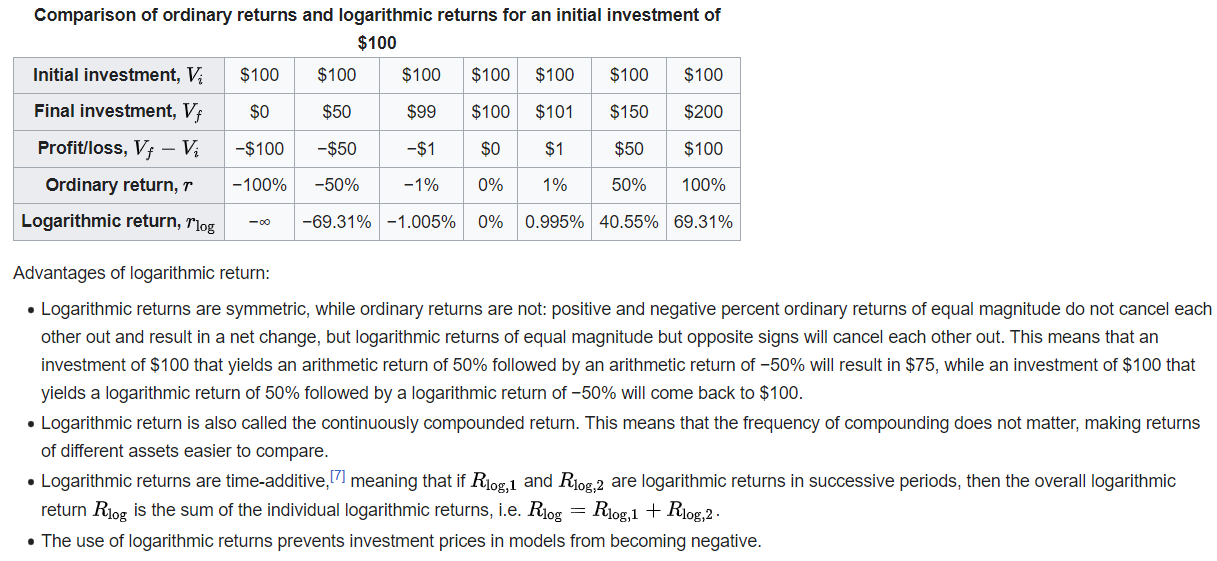

In [13]:
#check out log return and advantages: 
img4 = Image.open('log.png')
display(img4)

### <span style="color:blue"> The expected rate of annual returns is derived exclusively from historical data, and rates vary greatly depending on the time frame I chose. For instance, stocks are going to the moon in 2020 and 2021, followed by a free fall in 2022. It's important to note that this information is not intended as an investment recommendation but solely for educational purposes. </span>

### Calculate $Rf$

In [14]:
# Risk free rate use average 10-yr Treasure bill. For simplicity, 2.0% is often used.   
risk_free_rate= yf.download('^TNX', start='2013-01-01', end=None)['Adj Close']
risk_free_rate=risk_free_rate.mean()/100 
risk_free_rate #2.3% looks right

[*********************100%%**********************]  1 of 1 completed


0.02300717509157405

### Define the objective function

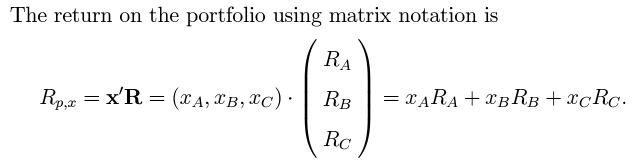

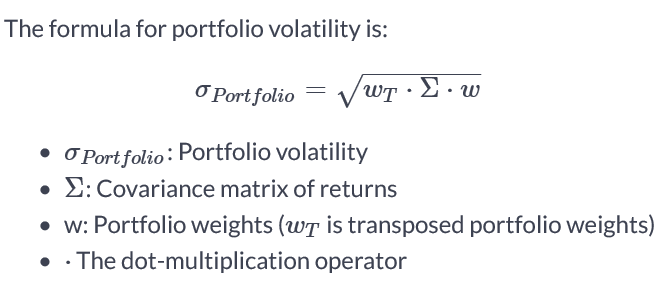

In [15]:
# show mathematical formula for Sharpe Ratio. In this problem, the hard part is to find the porfolio volatility. 
# Note: volatility is derived exclusively from historical data too. 
# As a result, it varies significantly depending on the time frame.
 
img2 = Image.open('portfolio_return.png') 
img3 = Image.open('volatility_formula.png') 
display(img2, img3)

In [16]:
# Note: function return negative Sharpe ratio. 
# Note: Scipy.optimize only compute minimize.
# To find the maximum positive Sharpe ratio is equivalent to find the minimum negative Sharpe ratio. 

def objective(weights):
    portfolio_return = np.dot(weights, annual_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov()*252, weights)))
    return -(portfolio_return-risk_free_rate) / portfolio_volatility 

In [17]:
cov_mtx = daily_returns.cov()*252
display(cov_mtx)

,AAPL,MSFT,NVDA,TSLA
AAPL,0.101473,0.072590,0.105514,0.096140
MSFT,0.072590,0.091709,0.109092,0.087716
NVDA,0.105514,0.109092,0.266067,0.156828
TSLA,0.096140,0.087716,0.156828,0.409313


### Define constraints

In [18]:
# in this problem, the only constraint is: sum of weights equals to 1. 

def constraint_f(weights):
    sum=0
    for i in range(len(tickers)):
        sum=sum+weights[i]
    return sum-1 #SciPy interprets 'expression (= 0)' as an equality constraint. in this case, sum-1 = 0

constraints = [{'type': 'eq', 'fun': constraint_f}] 


### Define bounds

In [19]:
# I set weights within the range of 0 to 100%, Intuitively each individual asset can not exceed 100% of the total portfolio.
# I am not considering short postions so there are no negative weights. 

bounds = (0,1)  
bounds = [bounds]*len(tickers)
bounds

[(0, 1), (0, 1), (0, 1), (0, 1)]

### Initial guess

In [20]:
# set initial_weights = evenly divided

initial_weights = [1 / len(tickers)] * len(tickers)
initial_weights

[0.25, 0.25, 0.25, 0.25]

### Run optimization

In [21]:
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
result 

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.8577531957843151
       x: [ 2.952e-01  4.551e-01  1.133e-01  1.364e-01]
     nit: 7
     jac: [-7.255e-02 -7.258e-02 -7.251e-02 -7.356e-02]
    nfev: 35
    njev: 7

### Display results

In [22]:
optimal_weights = result['x']
optimal_sharpe_ratio = -result['fun']
optimal_portfolio_return = np.dot(optimal_weights, annual_returns)

print("Optimal Weights:", optimal_weights)
print("Optimal Sharpe Ratio:", optimal_sharpe_ratio)
print("OptimalPortfolio Return:", optimal_portfolio_return)

Optimal Weights: [0.29516907 0.45512229 0.11328638 0.13642225]
Optimal Sharpe Ratio: 0.8577531957843151
OptimalPortfolio Return: 0.2944712305140935


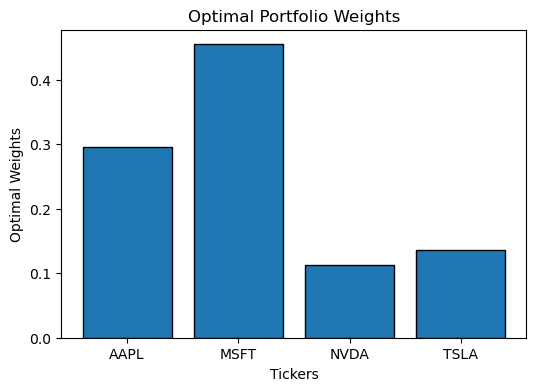

In [23]:
plt.figure(figsize=(6, 4))
plt.bar(tickers, optimal_weights, edgecolor='k')

plt.xlabel('Tickers')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

### Homework question: minimize  $f(x_1, x_2) = (x_1+11)^2 + (x_2-16)^2 - x_1x_2$
#### constrains st: 
$x_1-2x_2+2\le2$ 

$-x_1-2x_2+6=4$
#### bounds on x1, x2:
$x_1\ge0$

$x_2\ge0$